# Strain Optimization in MEWpy

This notebook exemplifies how MEWpy may be used in strain optimization tasks.
We will consider the as goal to increase the production of succinate in E. coli in anaerobic conditions.

In [1]:
%matplotlib inline
from cobra.io.sbml import read_sbml_model
model = read_sbml_model("data/e_coli_core.xml.gz")

Analyse the model's default medium

In [2]:
from mewpy.simulation.environment import Environment
import pandas as pd

medium = Environment.from_model(model).get_compounds()
env = Environment.from_compounds(medium)
pd.DataFrame(env,index=['lb','ub']).T


,lb,ub
EX_co2_e,-10.0,inf
EX_glc__D_e,-10.0,inf
EX_h_e,-10.0,inf
EX_h2o_e,-10.0,inf
EX_nh4_e,-10.0,inf
EX_o2_e,-10.0,inf
EX_pi_e,-10.0,inf


Commercial solvers are better suited to address optimization tasks, such, as stain designs. As such, you might want to check the linear programming solvers available on your system:

In [3]:
from mewpy.simulation import solvers
solvers

['cplex', 'glpk']

## Optimization problem

Before running any optimization let us verify the production rate as well as the theoretic maximum rate of succinate in anaerobic conditions.
To ease the script reutilization we will define some reaction identifiers as constants:

In [4]:
BIOMASS = 'BIOMASS_Ecoli_core_w_GAM'
PRODUCT = 'EX_succ_e'
O2 = 'EX_o2_e'
GLC = 'EX_glc__D_e'

In [5]:
anaerobic = {O2: (0, 0)}

In [7]:
from mewpy.simulation import get_simulator
sim = get_simulator(model,envcond=anaerobic)
sim.FVA(reactions=[PRODUCT],format='df')

,Reaction ID,Minimum,Maximum
0,EX_succ_e,0.0,1.911


In [8]:
sim.simulate(method='pFBA').find([BIOMASS,PRODUCT])

,Reaction ID,Flux rate
0,BIOMASS_Ecoli_core_w_GAM,0.211663
1,EX_succ_e,-0.000000


The optimization problem requires the definition of one or more objective functions.
In the next example, we define as objective the maximization of the Biomass-Product coupled yield and the maximization of the targeted product. MEWpy makes available other optimization objectives, please refer to the documentation.

In [25]:
from mewpy.optimization.evaluation import BPCY, TargetFlux, ModificationType

objs = [ 
    BPCY(BIOMASS, PRODUCT),
    TargetFlux(PRODUCT),
    ModificationType()
]

We can now define the growth medium and select the type of modification.
We will begin by performing gene deletion (GKO) by selecting the appropriate problem instance, GKOProblem. 

In [10]:
from mewpy.problems import GKOProblem, GOUProblem

problem = GOUProblem(model, objs, envcond=anaerobic, candidate_max_size=10)

Other optimization methods/strategies may be used:
* Reaction deletion: *RKOProblem*
* Reaction under or over expression: *ROUProblem*
* Gene under or over expression: *GOUProblem*

A problem may include other parameters, such as the maximum number of genetic modification, a list of specitic targets, or non-targets (reactions/genes not to be modified). 

## Optimization algorithm

An optimization engine to solve the problem need to be instanciated. MEWpy uses Evolutionary Algorithms (EA) for this task.

EAs are algorithms that mimic the Darwinian evolutionary process, where a population of solutions evolves generation after generation. In the example we define a maximum of 50 generations.  

In [11]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=20)

For informations on additional options you may use the `help` command

In [ ]:
help(EA)

The EA may contemplate aditional parameters such as the identification of a specific algorithm (e.g. SPEA2, NSGAII, NSGAIII, GDE3, etc.), multiprocessing options, initial seeding, etc.

To start the optimization process invoke the run method:

In [12]:
solutions = ea.run()

Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  -0.000000  0.253703  0.000000  0.003020  0.025648|  -0.000000  1.662235  0.000000  0.018984  0.166816|
    200|  -0.000000  0.834491  0.000000  0.013194  0.087529|  -0.000000  7.097740  0.000000  0.099406  0.726403|
    300|  -0.000000  0.834491  0.000000  0.045528  0.164331|  -0.000000  7.097740  0.000000  0.358066  1.398445|
    400|  -0.000000  0.841615  0.000000  0.126206  0.256732|  -0.000000  7.801256  0.000000  0.997240  2.215039|
    500|  -0.000000  0.841615  0.253703  0.323021  0.331958|  -0.000000  7.801256  1.652859  2.569083  2.970088|
    600|  0.045781  0.841615  0.834491  0.720564  0.223254|  1.652859  7.843953  7.055392  6.232343  2.009968|
    700|  0.594861  0.841615  0.834491  0.830393  0.026870|  7.055392  9.110254  7.097740  7.153113  0.258671|
    800|  0.594861  0.849299  0.834491  0.825567  0.035987|  7.055392  9.110254  7.0977

We can now list the set of solutions:

In [13]:
df=ea.dataframe()
df

,Modification,Size,BPCY,TargetFlux
0,"{'b3956': 16, 'b3403': 0}",2,0.857213,7.380338
1,"{'b1761': 0.03125, 'b1136': 0.125, 'b0720': 8,...",4,0.290337,10.973555
2,"{'b1761': 0.03125, 'b3403': 0, 'b2914': 4, 'b3...",5,0.621729,8.753395
3,"{'b1136': 0.125, 'b0720': 8, 'b3403': 0, 'b395...",4,0.290337,10.973555
4,"{'b3956': 16, 'b3403': 0, 'b1761': 0, 'b0720': 8}",4,0.590648,9.117232
5,"{'b3956': 16, 'b3403': 0, 'b1761': 0, 'b1136': 4}",4,0.775218,8.749446
6,"{'b3403': 0, 'b1761': 0.5, 'b3956': 16, 'b3734...",4,0.846719,7.421537
7,"{'b3403': 0, 'b3956': 16, 'b1136': 2, 'b3734':...",5,0.803881,8.057122
8,"{'b0720': 8, 'b1761': 0.25, 'b3956': 16}",3,0.618979,9.070078
9,"{'b3403': 0, 'b1761': 0.25, 'b3956': 16, 'b113...",5,0.826924,7.974331


Or view the best solutions on the objective space, the so called Pareto front:

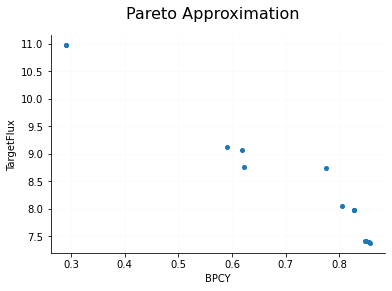

In [14]:
ea.plot()

We can save the solutions to file:

In [15]:
df.to_csv('solutions.csv')

or performe additional analysis on the solutions by retreiving the simulator used during the optimization.
 

## Working with solutions

Let us select the first solution:

In [17]:
#solutions
solution = solutions[0]
solution

[0.8572131947589658, 7.38033806993072];{'b3956': 16, 'b3403': 0}

The solution is converted to metabolict constraints to be applied to the model. We can access these constrains using *solution.constraints*

In [18]:
solution.constraints

{'PPC': (9.704661580184096, 10000), 'PPCK': (0, 0)}

We may run phenotypic simulations with the solution using those constraints. Note that there is no need to redefine the medium as they are persistent in the simulator instance.

In [22]:
sim = problem.simulator
res=sim.simulate(constraints=solution.constraints,method='lMOMA')
res

objective: 0.0
Status: OPTIMAL
Constraints: OrderedDict([('EX_o2_e', (0, 0)), ('PPC', (9.704661580184096, 10000)), ('PPCK', (0, 0))])
Method:lMOMA

In [23]:
res.dataframe

,Reaction ID,Flux rate
0,ACALD,-1.675528
1,ACALDt,0.000000
2,ACKr,-9.178855
3,ACONTa,0.125312
4,ACONTb,0.125312
...,...,...
90,TALA,-0.020779
91,THD2,0.000000
92,TKT1,-0.020779
93,TKT2,-0.062708


In [24]:
res.find([PRODUCT,BIOMASS])

,Reaction ID,Flux rate
0,BIOMASS_Ecoli_core_w_GAM,0.116148
1,EX_succ_e,7.380338


In [ ]:
from mewpy.visualization.envelope import plot_flux_envelope

plot_flux_envelope(sim,BIOMASS,PRODUCT,constraints = solution.constraints)

## Exercice 1

Alter the notebook to run a gene over/under-expression (GOUProblem) optimization task. You may also try other optimization objectives (replacing or adding new objectives) such as `CandidateSize`, `ModificationType` or `BPCY_FVA`.

## Exercice 2

Alter the notebook to find possible genetic modifications for the increased production of ethanol (EX_etoh_e)

# Simulating user defined modifications

Genetic modifications at the gene, enzyme, transcription or regulatory levels need to be translated to the (pseudo) reaction level. This task is problem dependent and consequently requires the instantiation of a problem. If we do not intend run any optimization task, there is no need to define optimization objectives.

In [ ]:
problem = GOUProblem(model,[], envcond=anaerobic)
sim = problem.simulator

A solution for a GOUProblem is a dictionary of genes' expression folds, e.g.:

In [ ]:
solution = {'b3956': 8, 'b2914': 4}

You may get information on the genes using the simulator find functions

In [ ]:
sim.find_genes('b3956|b2914')

The gene expressions are converted by the problem into reaction constraints:

In [ ]:
constraints = problem.solution_to_constraints(solution)
constraints

that are used to run phenotypic simulations:

In [ ]:
sim.simulate(constraints=constraints).find()

This functionality allows, for example, to simulate a same genetic modification on different methods or using other GEMs.